## Statistical Programming with Python: Bike Sharing Prediction

By Team O2-2 (B)
Duarte Costa, Alejandro Fernandez, Aksel Husebo, Carolin Kroeger, Moritz Steinbrecher, Yegnesh Sundar, Karel Van Cauwenberge

### 1. Exploratory Data Analysis (descriptive analytics)

In [1]:
#Import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# Read the data
hour_df = pd.read_csv(
    "/Users/carolinkroeger/Desktop/hour.csv"
)

#### Data quality

First we will take a look at the quality of the variables and the possible relationship between them.

In [3]:
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

We will try to predict the count value as it is the sum of the casual and registered. This means we have to leave these values out for the modelling.

In [5]:
# Predict cnt so casual and registered can be left out
hour_df = hour_df.drop(["casual", "registered"], axis=1)

Initially, we tried to encode the "year" variable as 2011 and 2012. This, however, does not add any informational value for a categorical variable and as it decreased our R2 scores from our predictions, we removed this. See original code below

In [6]:
# Set the right values for yr
#hour_df.yr = hour_df.yr.replace({0: 2011, 1: 2012})

To check for missing values in our dataset, we used the seaborn library to build a heatmap, indicating potential missing values in the dataset

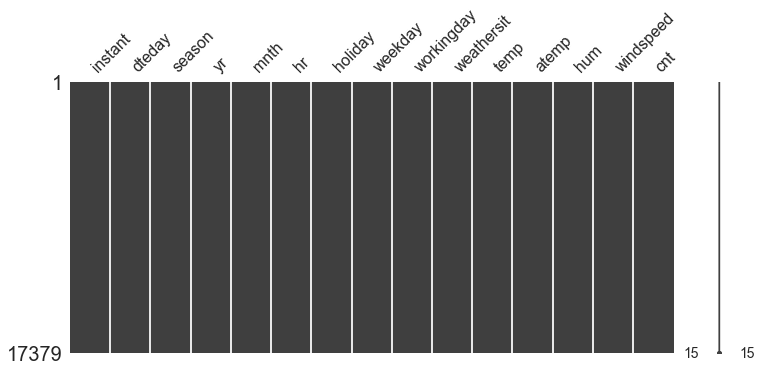

In [7]:
# Check for missing values
msno.matrix(hour_df, figsize=(12, 5))

Another problem would be the possible outliers in the dataset.
We checked the outliers using a boxplot representation

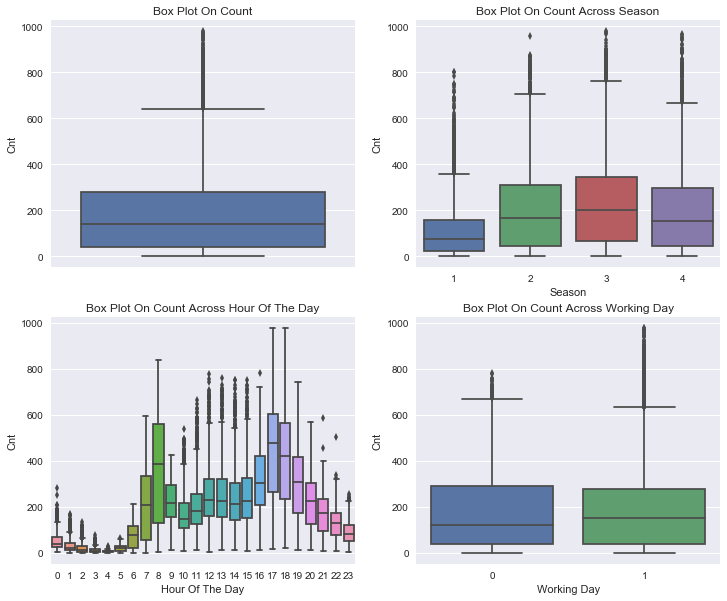

In [8]:
# Check for outliers using boxplots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hour_df, y="cnt", orient="v", ax=axes[0][0])
sns.boxplot(data=hour_df, y="cnt", x="season", orient="v", ax=axes[0][1])
sns.boxplot(data=hour_df, y="cnt", x="hr", orient="v", ax=axes[1][0])
sns.boxplot(data=hour_df, y="cnt", x="workingday", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel="Cnt", title="Box Plot On Count")
axes[0][1].set(xlabel="Season", ylabel="Cnt", title="Box Plot On Count Across Season")
axes[1][0].set(
    xlabel="Hour Of The Day",
    ylabel="Cnt",
    title="Box Plot On Count Across Hour Of The Day",
)
axes[1][1].set(
    xlabel="Working Day", ylabel="Cnt", title="Box Plot On Count Across Working Day"
)

As seen in the outlier detection, there where some outliers located in the numerical variables. We therefore tested our predictions with removing outliers outside three standard deviations from the mean of each variable. This process yielded the highest results when removing outliers only for "humidity"

In [9]:
# Eliminate the outliers detected using the boxplot.
#hour_no = hour_df[
    #np.abs(hour_df["windspeed"] - hour_df["windspeed"].mean()) <= (3 * hour_df["windspeed"].std())
#]

#hour_no = hour_no[
    #np.abs(hour_no["temp"] - hour_no["temp"].mean()) <= (3 * hour_no["temp"].std())
#]

hour_no = hour_df[
    np.abs(hour_df["hum"] - hour_df["hum"].mean()) <= (3 * hour_df["hum"].std())
]

#### Data visualization

Now that we ensured the data quality regarding outliers and msising values; the next step is to look for correlations between different variables in the dataset using a correlation matrix. There is an almost 1 to 1 relationship between temp and atemp which means we will leave one of them out for our modelling. In this case temp has the biggest effect on the count value so we leave out atemp.

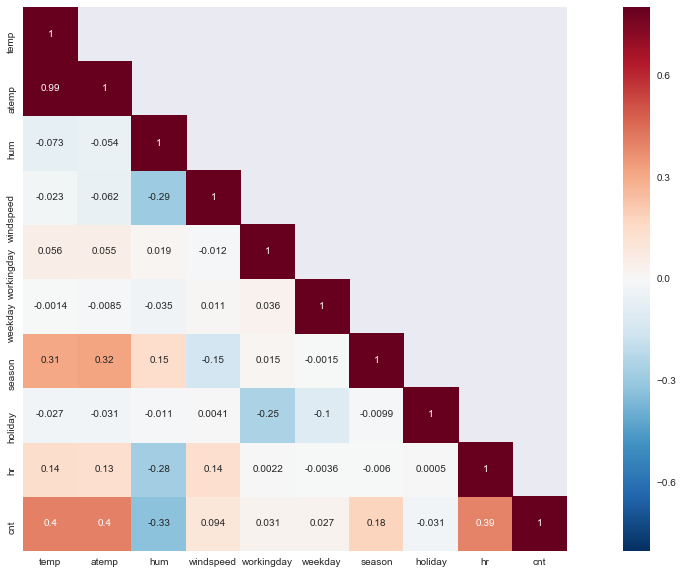

In [10]:
# Check the correlations of the different variables.
corrMatt = hour_no[
    [
        "temp",
        "atemp",
        "hum",
        "windspeed",
        "workingday",
        "weekday",
        "season",
        "holiday",
        "hr",
        "cnt",
    ]
].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)

In [11]:
# Remove temp because of the almost 1 to 1 correlation with atemp.
hour_no = hour_no.drop(["atemp"], axis=1)

Visualizing the data will show important insights for the modelling phase.
First of all we will take a look at the variables that showed the highest correlation with the cnt values in the correlation matrix: temp and hum. Showing a clearly linear relation between these two variable and the count variable.

 None]

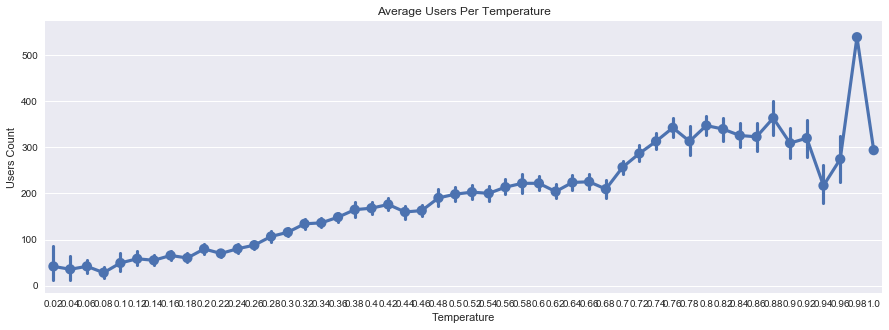

In [12]:
# Plot the temperature against the usage.
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 5)
sns.pointplot(x="temp", y="cnt", data=hour_no, join=True, ax=ax1)
ax1.set(
    xlabel="Temperature",
    ylabel="Users Count",
    title="Average Users Per Temperature",
    label="big",
)

 None]

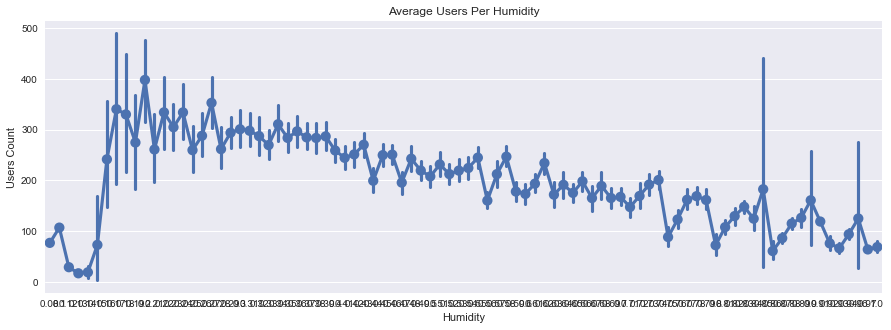

In [13]:
# Plot the humidity against the usage.
fig, ax6 = plt.subplots()
fig.set_size_inches(15, 5)
sns.pointplot(x="hum", y="cnt", data=hour_no, join=True, ax=ax6)
ax6.set(
    xlabel="Humidity",
    ylabel="Users Count",
    title="Average Users Per Humidity",
    label="big",
)

Now it will be interesting to take a look at the distribution of the rentals over the different months.

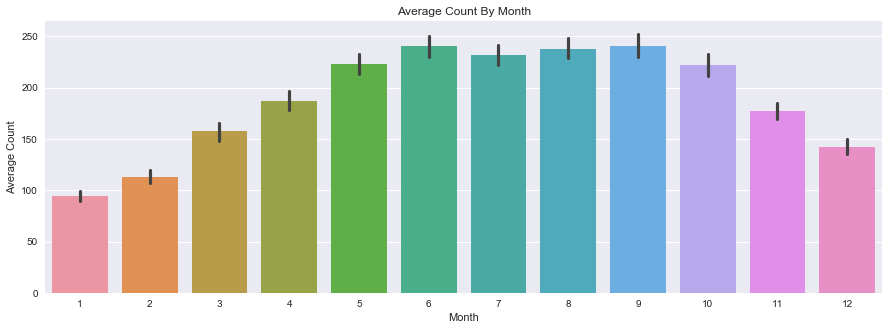

In [14]:
# Plot Monthly Distribution
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 5)

sns.barplot(data=hour_no, x="mnth", y="cnt", ax=ax1)
ax1.set(xlabel="Month", ylabel="Average Count", title="Average Count By Month")

Looking at the distribution of the rentals on a daily basis there are clearly periods of higher demand during a day, ie the moments people have to get home from/ go to work/school, and the other moments of the day.
Of course there is a big seasonal effect as well as an effect of wheteher it is a working day or not.

 None]

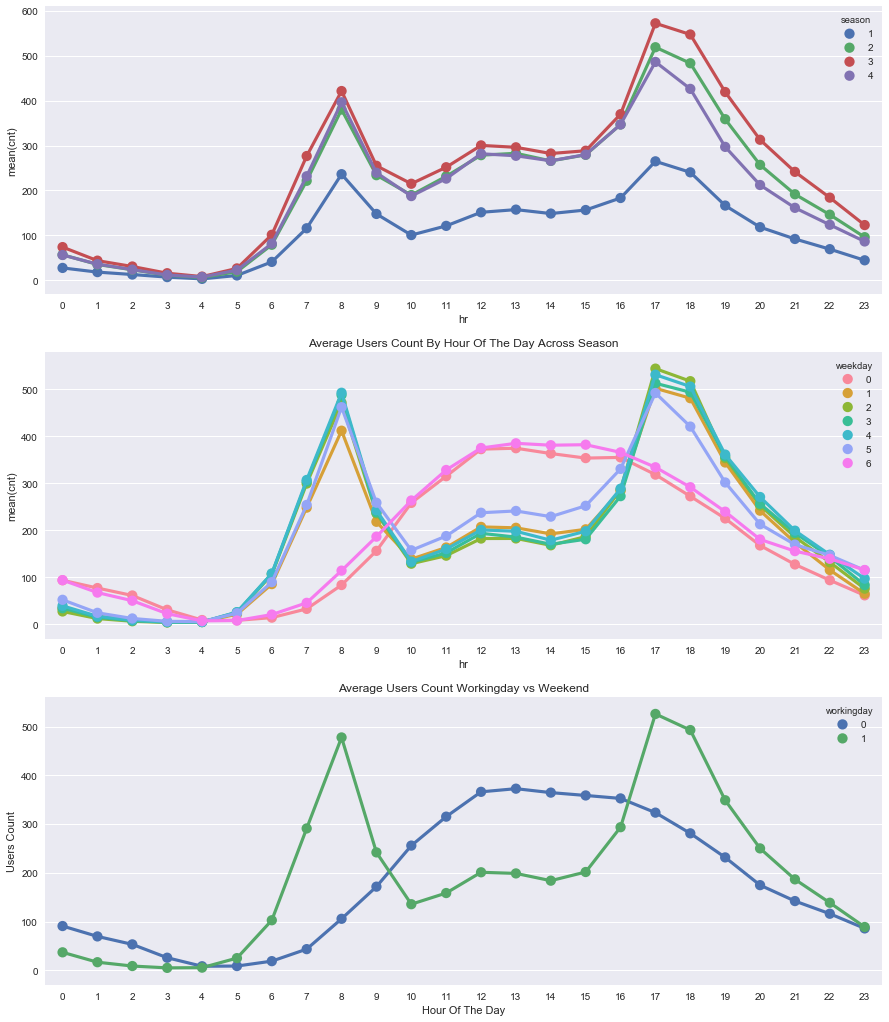

In [15]:
# Plot hourly distributions regarding season, day of week, workday
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
fig.set_size_inches(15, 18)

hourAggregated = pd.DataFrame(
    hour_no.groupby(["hr", "season"], sort=True)["cnt"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hr"],
    y=hourAggregated["cnt"],
    hue=hourAggregated["season"],
    data=hourAggregated,
    join=True,
    ax=ax1,
)
ax2.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Season",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_no.groupby(["hr", "weekday"], sort=True)["cnt"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hr"],
    y=hourAggregated["cnt"],
    hue=hourAggregated["weekday"],
    data=hourAggregated,
    join=True,
    ax=ax2,
)
ax3.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Weekdays",
    label="big",
)

hourAggregated = pd.DataFrame(
    hour_no.groupby(["hr", "workingday"], sort=True)["cnt"].mean()
).reset_index()
sns.pointplot(
    x=hourAggregated["hr"],
    y=hourAggregated["cnt"],
    hue=hourAggregated["workingday"],
    data=hourAggregated,
    join=True,
    ax=ax3,
)
ax3.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count Workingday vs Weekend",
    label="big",
)

#### Data visualization

The windspeed variable is showing a lot of 0 values, while it is almost impossible that there is 0 wind. That is why we decided to impute the 0 values of windspeed using a random forest regressor based on season, weather situation, humidity, month, temperature and year to estimate the values of windspeed in these cases.

In [16]:
# Check number of 0 values in windspeed
len(hour_no[hour_no["windspeed"] == 0])

2180

In [17]:
dataWind0 = hour_no[hour_no["windspeed"] == 0]
dataWindNot0 = hour_no[hour_no["windspeed"] != 0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season", "weathersit", "hum", "mnth", "temp", "yr"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
dataws = dataWindNot0.append(dataWind0)

In [18]:
dataws.sort_index(inplace=True)
dataws.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.150003,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.149004,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.149004,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.147738,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.147738,1


#### Feature Creation

After transforming, imputing, deleting and creating some variables, we were able to create the final dataset (dataws) and made sure it uses the right formats for the different datatypes.

In [19]:
# Convert final data in right format
dataws["season"] = dataws["season"].astype("category")
dataws["yr"] = dataws["yr"].astype("category")
dataws["mnth"] = dataws["mnth"].astype("category")
dataws["hr"] = dataws["hr"].astype("category")
dataws["weekday"] = dataws["weekday"].astype("category")
dataws["workingday"] = dataws["workingday"].astype("category")
dataws["holiday"] = dataws["holiday"].astype("category")
dataws["weathersit"] = dataws["weathersit"].astype("category")

In [20]:
# Convert final data in right format
dataws["temp"] = dataws["temp"].astype("float")
dataws["hum"] = dataws["hum"].astype("float")
dataws["windspeed"] = dataws["windspeed"].astype("float")

In [21]:
dataws.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.150003,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.149004,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.149004,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.147738,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.147738,1


### 2. Machine Learning (predictive analytics)

### 2.1 Linear regression

We will start using the dataset with no outlayers and without the wind values inputed using the random forest, to check later the positive or negative influence of this inputation to the model results.

We know that the we have to predict the cnt values from the first of October of 2012, so we identify this record to make our train/test split

We will start using the dataset with no outlayers and without the wind values inputed using the random forest, to check later the positive or negative influence of this inputation to the model results.

We know that the we have to predict the cnt values from the first of October of 2012, so we identify this record to make our train/test split

In [22]:
hour_no[hour_no["dteday"] == "2012-10-01"].head(1)
hour_no_train = hour_no[hour_no["instant"]<15212]
hour_no_train = hour_no[hour_no["instant"]>=15212]

First we get rid of date and instance, as they do not add info to the model

In [23]:
hour_no_to_use = hour_no_train.loc[:, "season":"windspeed"]
hour_no_to_use.shape

(2168, 11)

In [24]:
hour_no_train = hour_no.iloc[0:15212,:]
hour_no_test = hour_no.iloc[15212:17135]

We check the percentage of data that we are using for test

In [25]:
hour_no_test.shape[0]/(hour_no_train.shape[0]+hour_no_test.shape[0])

0.11222643711701197

We now define the columns for the model fit. We start first without binarizing "cathegorical ones", and try latter so see the results after OneHotEncoding them. We will not use instant as it will add no information and date as we have the date info splitted into other variables

In [26]:
hour_no_train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [27]:
hour_no_train_X = hour_no_train.loc[:, "season":"windspeed"]

Check the results of the dataset to train

In [28]:
hour_no_train_X.head(1)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0


In [29]:
hour_no_train_label = hour_no_train.loc[:,"cnt"]
hour_no_train_label.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

Now we build the most basic model with Linear Regression

In [30]:
LR = LinearRegression(fit_intercept=True)

In [31]:
LR_model_baseline = LR.fit(hour_no_train_X, hour_no_train_label)

In [32]:
hour_no_test_X = hour_no_test.loc[:, "season":"windspeed"]

In [33]:
LR_baseline_predicted = LR_model_baseline.predict(hour_no_test_X)

In [34]:
actual_label_test = hour_no_test.loc[:, "cnt"]

In [35]:
print("R2:")
metrics.r2_score(
    actual_label_test,
    LR_baseline_predicted,
    sample_weight=None,
    multioutput="uniform_average",
)

R2:


0.27224104249585035

In [36]:
print("Mean Squared Error:")
metrics.mean_squared_error(
    actual_label_test,
    LR_baseline_predicted,
    sample_weight=None,
    multioutput="uniform_average",
)

Mean Squared Error:


30392.661445535283

We see from the R squared and MSE that the result is not good. We will encode our categorical variables to find a better result

In [37]:
hour_no.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

We select the ones that are "categorical" meaning that even being numerical variables its meaning is not numeric

In [38]:
to_bin = hour_no[['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']]

In [39]:
enc = OneHotEncoder(handle_unknown='ignore')

As we will normalize our numerical variables later, we want to avoid that the OneHotEncoder gives artificially more weight than the numeric variables. For this reason we multiply by 0.7

In [40]:
matrix_enc = enc.fit_transform(to_bin)*0.7

In [41]:
matrix_enc_d = pd.DataFrame(matrix_enc.todense())

We add back the values of our numeric variables. For doing this we re set the index to the original one. Otherwise we find problems when adding the variables from the old datase

In [42]:
matrix_enc_d = matrix_enc_d.set_index(hour_no.index)

In [43]:
matrix_enc_d["temp"] = hour_no["temp"]
matrix_enc_d["hum"] = hour_no["hum"]
matrix_enc_d["windspeed"] = hour_no["windspeed"]

In [44]:
matrix_enc_d.shape

(17357, 56)

Now we split again between test and train

In [45]:
enc_train = matrix_enc_d.iloc[0:15212,:]
enc_test = matrix_enc_d.iloc[15212:17135,:]

We make sure that the dimensions are correct

In [46]:
len(enc_train)+len(enc_test)==len(hour_no)

False

Now we are ready to use our linear model now to fit on our binarized dataset

In [47]:
LR_model_HotEncoded = LR.fit(enc_train,hour_no_train["cnt"])

In [48]:
predictions_encoded = LR_model_HotEncoded.predict(enc_test)

In [49]:
print("R2:")
metrics.r2_score(
    actual_label_test,
    predictions_encoded,
    sample_weight=None,
    multioutput="uniform_average",
)

R2:


0.64973384227029973

In [50]:
print("Mean Squared Error:")
metrics.mean_squared_error(
    predictions_encoded,
    LR_baseline_predicted,
    sample_weight=None,
    multioutput="uniform_average",
)

Mean Squared Error:


9261.628134690769

So we see that the OneHotEncoder, as expected, improves the prediction thoroughly. Now the next step will me normalizing our numeric variables and check the results

We take each of our numeric the variables, convert them into a numpy array in order to reshape in such a form that the MinMaxScaler can understand. Mi

In [51]:
temp_norm = np.array(hour_no["temp"])
temp_norm_rs = temp_norm.reshape(-1, 1)
normalizer = preprocessing.MinMaxScaler()
temp_nor_out = normalizer.fit_transform(temp_norm_rs)
temp_nor_out

array([[ 0.2244898 ],
       [ 0.20408163],
       [ 0.20408163],
       ..., 
       [ 0.24489796],
       [ 0.24489796],
       [ 0.24489796]])

We plot the results to check that it works fine

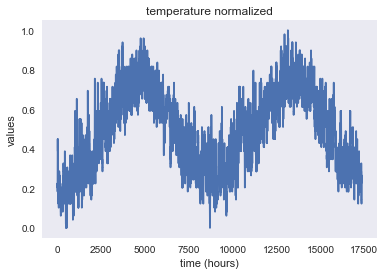

In [52]:
fig, ax = plt.subplots()
ax.plot(temp_nor_out)

ax.set(xlabel='time (hours)', ylabel='values',
       title='temperature normalized')
ax.grid()

fig.savefig("test.png")
plt.show()

In [53]:
hum_norm = np.array(hour_no["hum"])
hum_norm_rs = hum_norm.reshape(-1, 1)
normalizer = preprocessing.MinMaxScaler()
hum_nor_out = normalizer.fit_transform(hum_norm_rs)
hum_nor_out

array([[ 0.79347826],
       [ 0.7826087 ],
       [ 0.7826087 ],
       ..., 
       [ 0.56521739],
       [ 0.52173913],
       [ 0.61956522]])

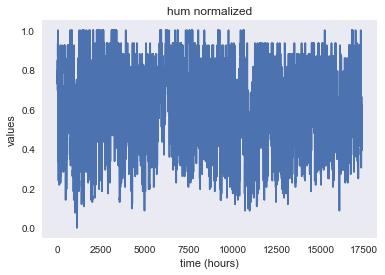

In [54]:
fig, ax = plt.subplots()
ax.plot(hum_nor_out)

ax.set(xlabel='time (hours)', ylabel='values',
       title='hum normalized')
ax.grid()

fig.savefig("test.png")
plt.show()

In [55]:
windspeed_norm = np.array(hour_no["windspeed"])
windspeed_norm_rs = windspeed_norm.reshape(-1, 1)
normalizer = preprocessing.MinMaxScaler()
windspeed_nor_out = normalizer.fit_transform(windspeed_norm_rs)
windspeed_nor_out

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ..., 
       [ 0.19301751],
       [ 0.15786999],
       [ 0.15786999]])

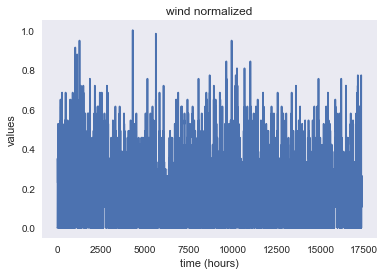

In [56]:
fig, ax = plt.subplots()
ax.plot(windspeed_nor_out)

ax.set(xlabel='time (hours)', ylabel='values',
       title='wind normalized')
ax.grid()

fig.savefig("test.png")
plt.show()

Now we build them back together in a dataframe to put them back in our model

In [57]:
numeric_scaled = pd.DataFrame({"temp_norm":temp_norm})
numeric_scaled["hum_norm"]=hum_nor_out
numeric_scaled["windspeed_norm"]=windspeed_nor_out

In [58]:
numeric_scaled.head()

,temp_norm,hum_norm,windspeed_norm
0,0.24,0.793478,0.0
1,0.22,0.782609,0.0
2,0.22,0.782609,0.0
3,0.24,0.728261,0.0
4,0.24,0.728261,0.0


In [59]:
numeric_scaled.shape

(17357, 3)

Next step is append this columns to our OneHotEncoded dataframe with the binarized cathegories

In [60]:
matrix_enc_d_norm = pd.DataFrame(matrix_enc.todense())

In [61]:
matrix_enc_d_norm["temp_norm"] = numeric_scaled["temp_norm"]
matrix_enc_d_norm["hum_norm"] = numeric_scaled["hum_norm"]
matrix_enc_d_norm["windspeed_norm"] = numeric_scaled["windspeed_norm"]

In [62]:
matrix_enc_d_norm.shape

(17357, 56)

Train test split again

In [63]:
enc_norm_train = matrix_enc_d_norm.iloc[0:15212,:]
enc_norm_test = matrix_enc_d_norm.iloc[15212:17135,:]

Fit new model

In [64]:
LR_model_Encoded_Norm = LR.fit(enc_norm_train,hour_no_train["cnt"])

In [65]:
predictions_encoded_norm = LR_model_Encoded_Norm.predict(enc_test)

In [66]:
print("R2:")
metrics.r2_score(
    actual_label_test,
    predictions_encoded_norm,
    sample_weight=None,
    multioutput="uniform_average",
)

R2:


0.65063716985871656

In [67]:
print("Mean Squared Error:")
metrics.mean_squared_error(
    predictions_encoded_norm,
    LR_baseline_predicted,
    sample_weight=None,
    multioutput="uniform_average",
)

Mean Squared Error:


9249.7987247274941

The result of out scaling is actually negative for the prediction, so we will not use standarization in the next iteration

Finally we try using the windspeed inputation and OneHotEncoding

First we delete our winspeed column from the training dataset

In [68]:
data_enc_windinputed = matrix_enc_d.loc[:, :"hum"]

Now we include the imputed values for winspeed

In [69]:
data_enc_windinputed["wind_inputed"] = dataws["windspeed"]

In [70]:
data_enc_windinputed.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,temp,hum,wind_inputed
0,0.7,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.7,0.7,0.0,0.0,0.0,0.24,0.81,0.150003
1,0.7,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.7,0.7,0.0,0.0,0.0,0.22,0.80,0.149004
2,0.7,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.7,0.7,0.0,0.0,0.0,0.22,0.80,0.149004
3,0.7,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.7,0.7,0.0,0.0,0.0,0.24,0.75,0.147738
4,0.7,0.0,0.0,0.0,0.7,0.0,0.7,0.0,0.0,0.0,...,0.0,0.0,0.7,0.7,0.0,0.0,0.0,0.24,0.75,0.147738


In [71]:
enc_ws_inputed_train = data_enc_windinputed.iloc[0:15212,:]
enc_ws_inputed_test = data_enc_windinputed.iloc[15212:17135,:]

In [72]:
LR_model_Encoded_ws_inputed = LR.fit(enc_ws_inputed_train,hour_no_train["cnt"])

In [73]:
predictions_encoded_ws_inputed = LR_model_Encoded_ws_inputed.predict(enc_test)

In [74]:
print("R2:")
metrics.r2_score(
    actual_label_test,
    predictions_encoded_ws_inputed,
    sample_weight=None,
    multioutput="uniform_average",
)

R2:


0.64952329119334851

So we see that using the inputation oif wind does not give us a better result in terms of R2

### 2.3 Ridge regression

Since we are using many features, we also tried running a ridge regression on our dataset. We here tested the normalized encoded dataset.

In [90]:
enc_norm_train = matrix_enc_d_norm.iloc[0:15212,:]
enc_norm_test = matrix_enc_d_norm.iloc[15212:17135,:]

For this model we are using the RMSLE estimator as a scoring measure.
The function beneath is defining this estimator.

In [91]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [92]:
ridge_model = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_model,
                          ridge_params_,
                            scoring = rmsle_scorer,
                          cv=10)
grid_ridge_m.fit( enc_norm_train, yLabels)
ridge_preds = grid_ridge_m.predict(X= enc_norm_test)

/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: 

/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel 

/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel 

/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: 

/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/Users/akselhusebo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel 

In [93]:
print (grid_ridge_m.best_params_)
print ("R2 Value For Ridge Regression: ",r2_score(y_pred=ridge_preds, y_true=hour_no_test["cnt"]))

{'alpha': 0.1, 'max_iter': 3000}
R2 Value For Ridge Regression:  0.650204348738


This model yielded better results than the other linear ones, but the improvement is marginal. 

### 2.2 Random forest

Our baseline model did not yield high results, more complex models could solve this issue. In our first attempt to improve our R2 score we will also model with a random forest algorithm, this is done because our dataset contains both categorical and numerical variables

We used the hotencoded variables from our linear regression to perform our random forest, this dataset is just using the hotencoded ones, before normalizing

In [78]:
enc_train = matrix_enc_d.iloc[0:15212,:]
enc_test = matrix_enc_d.iloc[15212:17135,:]
yLabels = hour_no_train["cnt"]

In [79]:
regressor = RandomForestRegressor()
parameters = [
    {"n_estimators": [100, 150, 200, 250, 300], "max_features": ["auto", "sqrt", "log2"]}
]
grid_search = GridSearchCV(estimator=regressor, param_grid=parameters)
grid_search = grid_search.fit(enc_train, yLabels)
parameters_to_use = grid_search.best_params_

In [80]:
parameters_to_use

{'max_features': 'auto', 'n_estimators': 150}

In [81]:
rfModel = RandomForestRegressor(n_estimators=200)
rfModel.fit(enc_train,hour_no_train["cnt"])
preds_1st_forest = rfModel.predict(X= enc_test)

In [82]:
r2_score(y_pred=preds_1st_forest, y_true=hour_no_test["cnt"])

0.81599494969026243

The random forrest model is performing better than the linear regression but still leaves room for improvement. Lets first check how our model performs when we use the encoded variables including the predicted missing variables we used earlier. We also ran this model using the normalized encoded variables, however, this did not yield better results, most likely because of skewness in the original dataset

First, lets call the wind imputed variables

In [83]:
enc_ws_inputed_train = data_enc_windinputed.iloc[0:15212,:]
enc_ws_inputed_test = data_enc_windinputed.iloc[15212:17135,:]
yLabels = hour_no_train["cnt"]

In [84]:
regressor = RandomForestRegressor()
parameters = [
    {"n_estimators": [100, 150, 200, 250, 300], "max_features": ["auto", "sqrt", "log2"]}
]
grid_search = GridSearchCV(estimator=regressor, param_grid=parameters)
grid_search = grid_search.fit(enc_ws_inputed_train, yLabels)
parameters_to_use = grid_search.best_params_

In [85]:
parameters_to_use

{'max_features': 'auto', 'n_estimators': 250}

In [86]:
rfModel = RandomForestRegressor(n_estimators=200)
rfModel.fit(enc_train,hour_no_train["cnt"])
preds_2nd_forest = rfModel.predict(X= enc_test)

In [87]:
r2_score(y_pred=preds_2nd_forest, y_true=hour_no_test["cnt"])

0.81892968040291136

This model is more or less similar to our results from the first random forest. Lets therefore see if we might not be overfitting our data when using only randomforests. 

### 2.4 Gradient Boost

As our dataset contains variables with many levels, we tried running our predictions with a gradient boost model. This also mitigates multicolinearity between the features, which is needed as the numerical variables are correlated (as seen in the EDA)

In [94]:
enc_train = matrix_enc_d.iloc[0:15212,:]
enc_test = matrix_enc_d.iloc[15212:17135,:]
yLabels = hour_no_train["cnt"]

In [95]:
gbm = GradientBoostingRegressor(n_estimators=5600,alpha=0.8);
gbm.fit(enc_train,yLabels)
preds_boost = gbm.predict(X= enc_test)
print ("R2 Value For Gradient Boost Regression: ",r2_score(y_pred=preds_boost, y_true=hour_no_test["cnt"]))

R2 Value For Gradient Boost Regression:  0.880453254263


Finally seeing some better results! This model is outperforming our others with a solid margin, since the predictions reacted positively to gradient boost, we might also improve our scores by using an "extreme" version of this algorythm

### 2.4 XB Boost

The XGboost model works in a similar fashion as the gradient boost, but is considered faster and mitigates better 

In [116]:
enc_train = matrix_enc_d.iloc[0:15212,:]
enc_test = matrix_enc_d.iloc[15212:17135,:]
yLabels = hour_no_train["cnt"]

In [117]:
xg_reg = xgb.XGBRegressor(max_depth = 5, alpha = 10, n_estimators = 5000, colsample_bytree=0.3)

In [118]:
xg_reg.fit(enc_train,yLabels)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [119]:
xgpreds = xg_reg.predict(enc_test)

In [120]:
len(xgpreds)

1923

In [121]:
print ("R2 Value For Gradient Boost Regression: ",r2_score(y_pred=xgpreds, y_true=hour_no_test["cnt"]))

R2 Value For Gradient Boost Regression:  0.888882183547


### 2.5 Conclusion

As illustrated below, our target variable is best predicted using an XGBoost model due to the high number of features we encoded and the multicoliniarity between 

In [123]:
y_test=hour_no_test["cnt"]

In [132]:
LG_r2 = metrics.r2_score(
    actual_label_test,
    predictions_encoded_norm,
    sample_weight=None,
    multioutput="uniform_average",
)
RF_r2 = float(r2_score(y_pred=preds_1st_forest, y_true=y_test))
Rid_r2 = float(r2_score(y_pred=ridge_preds, y_true=y_test))
XGB_r2 = float(r2_score(y_pred=xgpreds, y_true=y_test))
GrB_r2 = float(r2_score(y_pred=preds_boost, y_true=y_test))
data = [
    {
        "LogRegression": LG_r2,
        "RandomForest": RF_r2,
        "Ridge": Rid_r2,
        "XGBoost": XGB_r2,
        "GrB": GrB_r2,
    },
]

comparisonmetrics = pd.DataFrame(
    data,
    index=["r2"],
    columns=[
        "LogRegression",
        "RandomForest",
        "Ridge",
        "XGBoost",
        "GrB",
    ],
)

comparisonmetrics.round(2)

,LogRegression,RandomForest,Ridge,XGBoost,GrB
r2,0.65,0.82,0.65,0.89,0.88


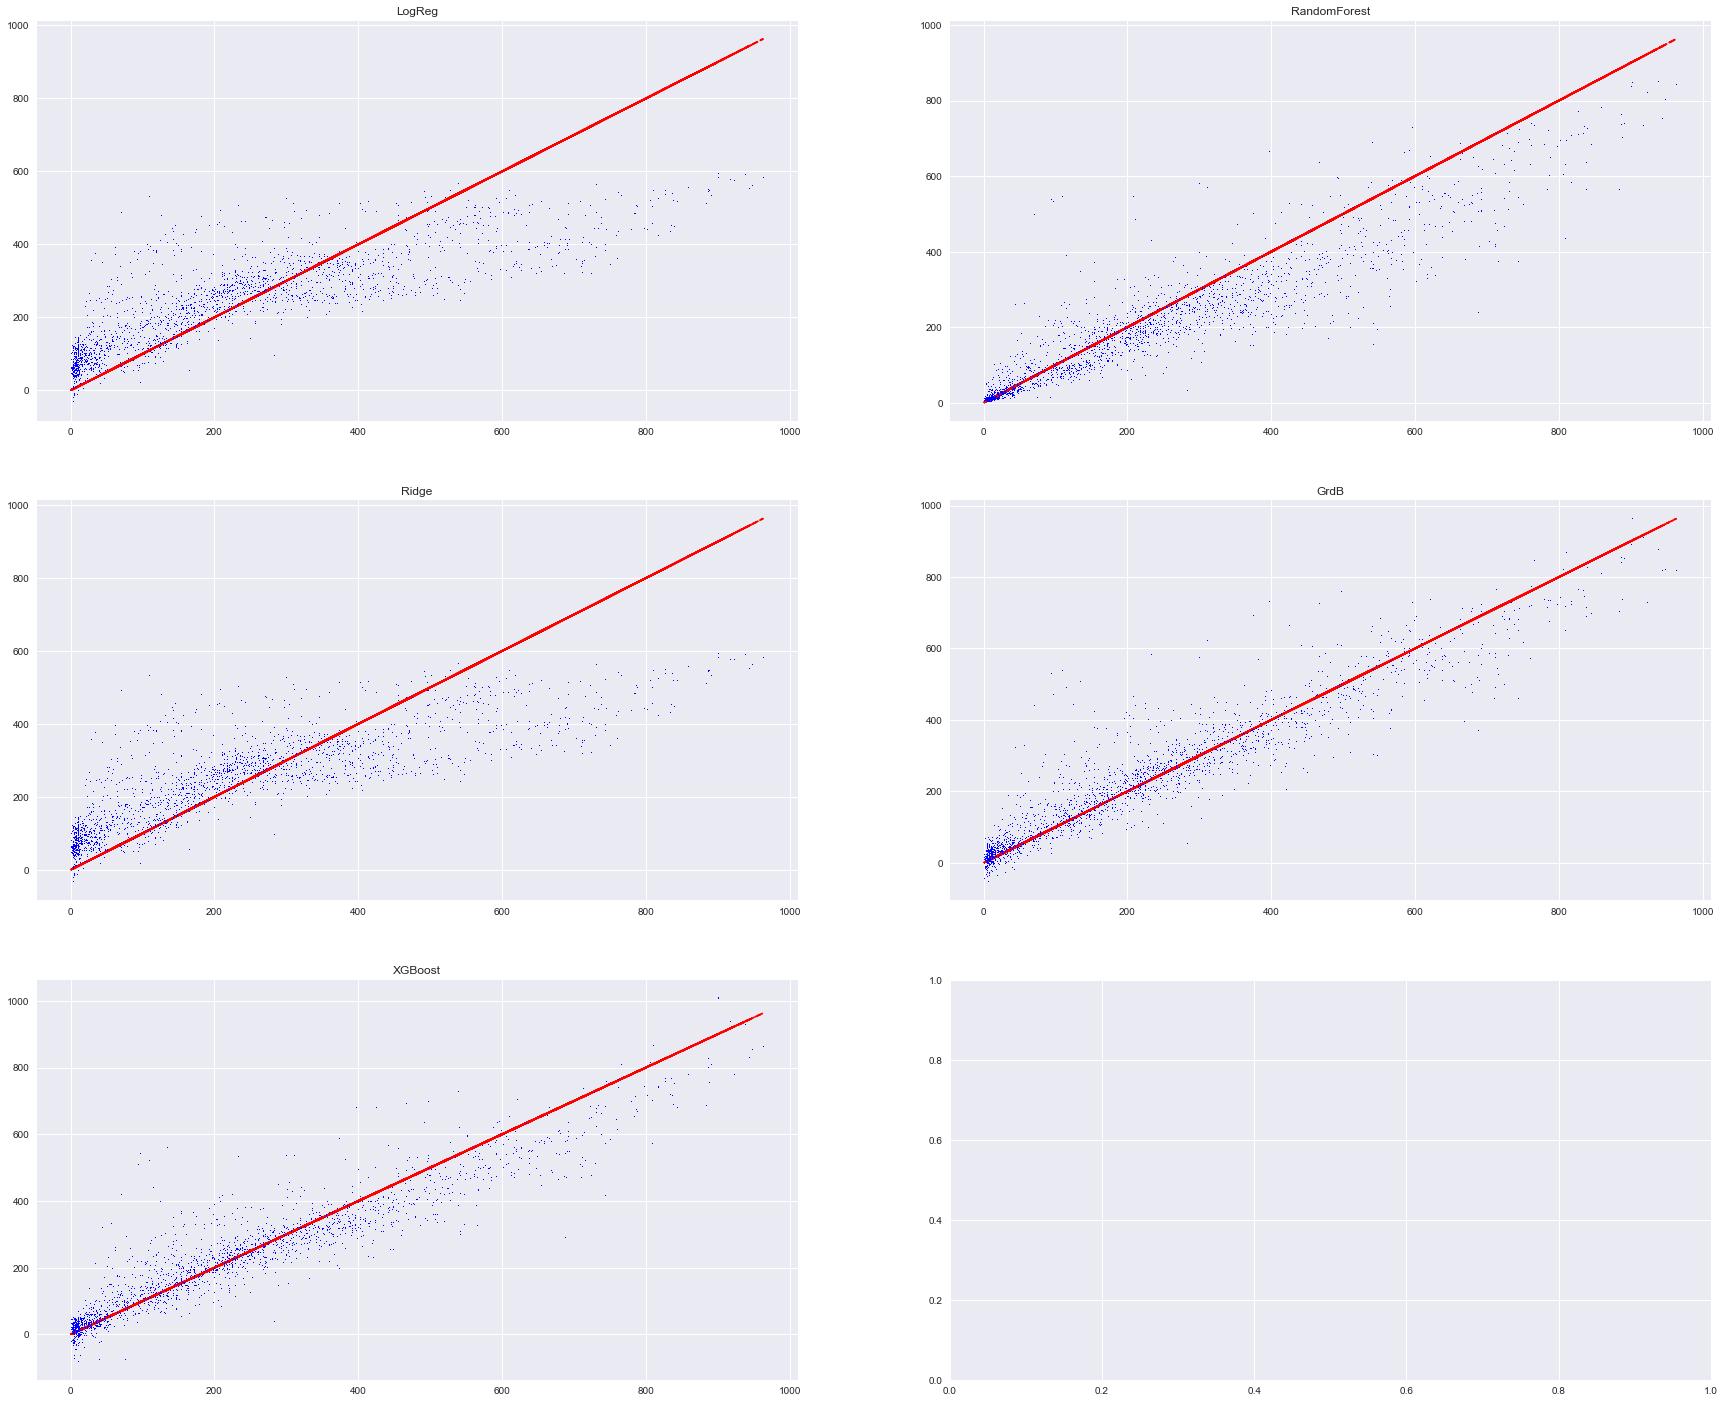

In [126]:
#here we plot the predictions of the various models against the actual values, so to compare them again. 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (30,25))

ax1 = axs[0,0]
ax1.plot(y_test, y_test, "r--", y_test, predictions_encoded_norm, "b,")
ax1.set_title('LogReg')

ax2 = axs[0,1]
ax2.plot(y_test, y_test, 'r--', y_test, preds_1st_forest , 'b,')
ax2.set_title('RandomForest')

ax1 = axs[1,0]
ax1.plot(y_test, y_test, 'r--', y_test, ridge_preds, 'b,')
ax1.set_title('Ridge')

ax2 = axs[1,1]
ax2.plot(y_test, y_test, 'r--', y_test, xgpreds, 'b,')
ax2.set_title('GrdB')

ax1 = axs[2,0]
ax1.plot(y_test, y_test, 'r--', y_test, preds_boost, 'b,')
ax1.set_title('XGBoost')